In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import tensorflow
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import time

In [2]:
path_to_dataset = "dataset/"
output_store_path = "graph_and_model_store_after_train/"
path_to_train_and_validation_loss_and_accuracy_plot = output_store_path + "plot.png"
#path_to_store_covid_19_image_recognition_model = output_store_path + "covid19.model"
path_to_store_covid_19_image_recognition_model = os.path.join("pb_format_model" , "my_model")


In [3]:
try:
    os.makedirs(output_store_path)    
    print("Directory " , output_store_path ,  " Created . ")
except FileExistsError:
    print("Directory " , output_store_path ,  " already exists . ")  


Directory  graph_and_model_store_after_train/  Created . 


In [4]:
# initialize the 
# initial learning rate = INIT_LR
# number of epochs = EPOCHS
# batch size = BS 

INIT_LR = 1e-3
EPOCHS = 25
BS = 8


In [5]:
# get the images in directory, 
# then initialize
# data (i.e., images) and class of images . 

print("[INFO] loading images...")
imagePaths = list(paths.list_images(path_to_dataset))
data = []
labels = []


[INFO] loading images...


In [6]:
# get image, convert color, resize each image in image paths 
# and 
# after that append each image and label data 

for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]

    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    
    #print(image.shape)
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    #print(image.shape)
    
    image = cv2.resize(image, (224, 224))

    #print(image.shape)
    
    # update the data and labels lists
    data.append(image)
    labels.append(label)


In [7]:
np.array(data).shape

(50, 224, 224, 3)

In [8]:
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 255]
data = np.array(data) / 255.0
labels = np.array(labels)


In [9]:
# one-hot encoding the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)


In [10]:
# split data into train and test data using 80% of
# the data for training and the remaining 20% for testing 

(trainX, testX, trainY, testY) = train_test_split(data, labels, 
                                test_size=0.20, stratify=labels, random_state=42)


In [11]:
# train image data augmentation by using ImageDataGenerator
trainAug = ImageDataGenerator(rotation_range=15, fill_mode="nearest")


In [12]:
# VGG16 network load and head FC layer sets are not used 

baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))


In [13]:
# construct the head of the model that will be placed on the base model

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)


In [14]:
# keep head FC model on the base model 
# and it is the model that will be trained . 
model = Model(inputs=baseModel.input, outputs=headModel)


In [15]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False


In [16]:
# compile model
print("[INFO] compiling model...")

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

print("compile done . ")


[INFO] compiling model...
compile done . 


In [17]:
# train the head of the network
print("[INFO] training head...")

start_time = time.time()

H = model.fit_generator(
    trainAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

print("--- train completed after %s seconds ---" % (time.time() - start_time))
print("train done . ")

[INFO] training head...
Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 5 steps, validate on 10 samples
Epoch 1/25
5/5 [==============================] - 78s 16s/step - loss: 0.7675 - accuracy: 0.5000 - val_loss: 0.5347 - val_accuracy: 0.5000
Epoch 2/25
5/5 [==============================] - 76s 15s/step - loss: 0.6937 - accuracy: 0.5750 - val_loss: 0.5039 - val_accuracy: 0.7500
Epoch 3/25
5/5 [==============================] - 75s 15s/step - loss: 0.7236 - accuracy: 0.5250 - val_loss: 0.4847 - val_accuracy: 0.8750
Epoch 4/25
5/5 [==============================] - 75s 15s/step - loss: 0.6486 - accuracy: 0.5500 - val_loss: 0.4665 - val_accuracy: 1.0000
Epoch 5/25
5/5 [==============================] - 76s 15s/step - loss: 0.5392 - accuracy: 0.7500 - val_loss: 0.4427 - val_accuracy: 0.8750
Epoch 6/25
5/5 [==============================] - 75s 15s/step - loss: 0.5201 - accuracy: 0.7500 - val_loss: 0.4267 - val_accuracy: 0.8750

In [18]:
# predictions on the test set

print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)


[INFO] evaluating network...


In [19]:
# for each image in the test data, index of the label 
# with corresponding largest predicted probability is found . 
predIdxs = np.argmax(predIdxs, axis=1)


In [20]:
# classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))


                precision    recall  f1-score   support

 dataset/covid       1.00      1.00      1.00         5
dataset/normal       1.00      1.00      1.00         5

      accuracy                           1.00        10
     macro avg       1.00      1.00      1.00        10
  weighted avg       1.00      1.00      1.00        10



In [21]:
# confusion matrix to find the raw accuracy, sensitivity, and specificity

cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])


In [22]:
# confusion matrix, accuracy, sensitivity, and specificity are printed . 
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))


[[5 0]
 [0 5]]
acc: 1.0000
sensitivity: 1.0000
specificity: 1.0000


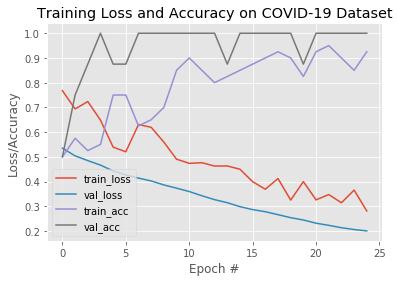

In [23]:
# plot the training loss and accuracy

N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(path_to_train_and_validation_loss_and_accuracy_plot)


In [24]:
# serialize the model to disk
print("[INFO] saving COVID-19 detector model...")
#model.save(path_to_store_covid_19_image_recognition_model, save_format="h5")
model.save(path_to_store_covid_19_image_recognition_model) 
print("covid-19 model file saved at location = ", path_to_store_covid_19_image_recognition_model)

[INFO] saving COVID-19 detector model...
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: pb_format_model\my_model\assets
covid-19 model file saved at location =  pb_format_model\my_model


In [25]:
model_stored = load_model(path_to_store_covid_19_image_recognition_model, compile=True)

In [28]:
path_to_store_covid_19_image_recognition_model

'pb_format_model\\my_model'

In [32]:
#model_stored.save("covid_19_image_recognition_model.pb")
converter = tensorflow.lite.TFLiteConverter.from_saved_model(path_to_store_covid_19_image_recognition_model)
tfmodel = converter.convert()
open("pb_format_model/"+"model.tflite","wb").write(tfmodel)

58998892

In [34]:

covid_19_path = "check covid 19 image/covid 19/"

not_covid_19_image = "check covid 19 image/not covid 19/"

path_to_covid_19_check_image_file = covid_19_path + "1-s2.0-S0929664620300449-gr2_lrg-b.jpg"

#path_to_covid_19_check_image_file = not_covid_19_image + "IM-0033-0001-0001.jpeg"


IMG_SIZE = 224
img_array = cv2.imread(path_to_covid_19_check_image_file)  
img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))

licht_1 = []

licht_1.append(new_array)

new_array = np.array(licht_1) / 255.0

#to predict single image
class_prob=model_stored.predict(new_array,batch_size=1)
print(class_prob)


def predict_classes_of_covid_19_image_file(class_prob):
    if np.argmax(class_prob, axis=1) == 0:
        return "input image is detected as covid 19 type image . ", np.argmax(class_prob, axis=1)
    else:
        return "input image is detected as NOT covid 19 type image . ", np.argmax(class_prob, axis=1)
        

classifications, indekch =predict_classes_of_covid_19_image_file(class_prob)
print(classifications) 

[[0.9150556 0.0849444]]
input image is detected as covid 19 type image . 
